## Title: Binary Classification using Bird Images with TensorFlow and CNN

Jupyter Junkies 

Noor Ashrifeh, Jake Krueger, Bang Nguyen, Son Tran

April 16, 2024

This analysis continues our study of computer vision and CNN by exploring the application of binary classifiers on images to distinguish between pairs of bird species.

## Introduction

This report focuses on using convolutional neural networks (CNNs) to classify images of bird species. In this lab, we utilize the Caltech-UCSD Birds-200-2011 Dataset (CUB 200), which contains 200 classes (different species), each containing roughly 60 images of various bird species in North America. This dataset was created by individuals from the California Institute of Technology and the University of California San Deigo by downloading images from the web and curating them with Amazon Mechanical Turk. The collection process consisted of performing a Flickr image search for each species and using MTurkers to filter the results. (Van Horn et al., 2015). The inspiration for this week's lab came from the article "Building a Bird Recognition App and Large Scale Dataset With Citizen Scientists: The Fine Print in Fine-Grained Dataset Collection," which was authored by the SE(3) Computer Vision Group at Cornell University, in collaboration with 'citizen scientists and domain experts,' has leveraged the Caltech-UCSD Birds-200-2011 Dataset to develop a new high-quality dataset. This initiative aims to foster the development of more advanced computer vision algorithms, underscoring the dataset's significant role in pushing the boundaries of computer vision research. Even though the article mentions how researchers and bird experts were able to identify a total of 494 errors in the CUB 200 dataset, with 252 images not belonging to the dataset and 242 images that needed to be moved to a different category, we still chose this dataset, as it would be much easier to manage due to its size, compared to the size of the NABirds dataset that the authors created.

The main goal of our analysis is to implement TensorFlow and CNNs to classify images, interpret the results of the CNN classifiers, and apply multiple pre-trained binary classifiers to predict the classification of a selected set of images. We will specifically target classifying ten pairs of bird species identified through an image similarity analysis that employs the ResNet50 neural network model from Keras. This pre-trained model uses the ImageNet database. The representation vector from the ResNet50 model and cosine similarity were used to measure the similarities between every pair for the first 50 species. The purpose of using cosine similarity to identify images that are the most (and least) similar to one another comes from the idea that it measures the similarity in the direction or orientation of the vector, becoming an effective measurement of the similarity between the vectors (Fareid, 2023). After that, we get the first five similar images and the last five similar images from the dataset. This approach entails extracting an image feature embedding that a neural network has created and comparing these feature embeddings to assess the similarity of two images. Based on our image similarity analysis results, we will look at the ten pairs of bird species during this analysis. More information about each pairing can be seen in the following section, _Image Simulary Analysis: Deep Learning-based Approach_(listed from highest similarity score to least):

1. Acadian Flycatcher vs. Least Flycatcher
2. Great Crested Flycatcher vs. Yellow-bellied Flycatcher
3. Brewer Blackbird vs. Shiny Cowbird
4. Acadian Flycatcher vs. Yellow-bellied Flycatcher
5. Brandt Cormorant vs. Pelagic Cormorant
6. Yellow-breasted Chat vs. Eared Grebe
7. Gadwall vs. American Goldfinch
8. Indigo Bunting vs. Eared Grebe
9. Black-footed Albatross vs. American Goldfinch
10. American Goldfinch vs. Eared Grebe

Due to our approach in picking our ten pairs of bird species through computing their cosine similarity scores, we hypothesize that the bird pairings with the most significant cosine similarity scores (1-5 from the list above) will have a much harder time making an accurate prediction between these species because these pairings share many features, making it harder for the classifiers to find distinctive features that can be used for differentiation, resulting in a much lower accuracy, precision, and recall score. 

We hypothesize that the bird pairings with the lowest cosine similarity score (6-10) will have much higher accuracy because each pair will have features that are much different from one another based on the lower cosine similarity score. This makes it easier for the classification model to find distinctive features, resulting in a higher accuracy, precision, and recall score.


The stakeholders in our analysis encapsulate more than just researchers who rely on accurate data for their scientific studies. However, it also can impact those who are a part of conservation groups who may rely on this information to identify species that may be at risk of going extinct, along with individuals from the broader public who have a genuine interest in what is flying around in their back yards and want to learn more about the birds in North America. 

As previously mentioned, the CUB 200 dataset we utilized had errors, as pointed out by Cornell University researchers. This raises ethical concerns about the dataset's accuracy and reliability. Despite this, the researchers still consider the CUB 200 dataset reliable, and its transparency in data collection helps build trust. However, these errors, particularly the misclassification of 242 images, can lead to flawed decision-making and potentially misleading conclusions about specific bird species. The ethical considerations for this lab extend well beyond applying these methods to images of birds and predicting on a set of images. Image processing and classification can come into play in various sectors, and ensuring accurate data is crucial. The designed applications follow a well-guided moral compass that can positively impact society and not take advantage of those who may be vulnerable to the inappropriate use of image classification. 





In [ ]:
from keras.preprocessing import image as img
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
tf.random.set_seed(42)

image_path = "CUB_200_2011/images"

### Image Simulary Analysis: Deep Learning Based Approach

In [2]:
# The load_images_keras takes a list of image filepaths, load them into numpy arrays, append the arrays to a list, and preprocess the arrays with the preprocess_input function.
def load_images_keras(image_list):
    images = []
    for i in image_list:
        this_pil = img.load_img(i, target_size = (224, 224))
        this_array = img.img_to_array(this_pil)
        c_img = np.expand_dims(this_array, axis = 0)
        images.append(c_img)
    return preprocess_input(np.vstack(images))

# The load_images_for_neural_network takes a list of filepaths and run a batch size of 64 image paths through the load_images_keras function 
#to yield a generator object with one iteration being one batch of images.
def load_images_for_neural_network(fnames, batch_size = 64):
    while True:
        cfns = []
        for i, p in enumerate(fnames):
            cfns.append(p)
            if len(cfns) == batch_size:
                yield load_images_keras(cfns)
                cfns = []
        if len(cfns) != 0:
            yield load_images_keras(cfns)
            cfns = []

# The glob_images_path fuction creates a list of the file path to the images in a label file
def glob_images_path(image_path, label):
    images = []
    label_path = os.path.join(image_path, label)
    
    for image_file in os.listdir(label_path):
        image_file_path = os.path.join(label_path, image_file)
    
        images.append(image_file_path)

    return images
# The calculate_similarity returns the similarity score between 2 embeddings
def calculate_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))


In [3]:
resnet_model = ResNet50(weights = 'imagenet', input_shape=(224,224,3), include_top=False, pooling='avg') #Resnet model to fit the images 
                                                                                                        #then compare the outputs to get the most similar pairs

similarity_dict = {}
folder_list = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))] #List of all the birds in the dataset
folder_list = sorted(folder_list)[:50]
embedding_dict = {}
for i in range(len(folder_list)):
    fnames = glob_images_path(image_path, folder_list[i]) # List of filepaths to the images in one label
    image = load_images_for_neural_network(fnames) # Create an image generator for that label
    embedding = resnet_model.predict(image, steps=1, verbose=0) # The model take one batch at a time from the image generator (step=1), output will be tensors containing embeddings
                                                                # verbose=0 to specify no output being printed to the console
    embedding = np.mean(embedding, axis=0) # Compute the mean embedding of all the embeddings for one label 
    embedding_dict[folder_list[i]] = embedding # Create a dictionary with the labels as the keys and their mean embeddings as the values
# This loop computes the similarity score between every pair of the 50 pairs
for i in range(len(folder_list)):
    for j in range(i+1, len(folder_list)):
        embedding1 = embedding_dict[folder_list[i]]
        embedding2 = embedding_dict[folder_list[j]]
        similarity = calculate_similarity(embedding1, embedding2)
        similarity_dict[(folder_list[i], folder_list[j])] = similarity



2024-04-16 21:06:51.322325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 21:06:51.340559: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# This code chunk returns the top 10 most similar pairs out of the first 50 species
top_5_keys = sorted(similarity_dict, key=similarity_dict.get, reverse=True)[:5]
last_5_keys = sorted(similarity_dict, key=similarity_dict.get, reverse=True)[-5:]
my_working_pairs = []
for key in top_5_keys:
    my_working_pairs.append(key)
    print(key, similarity_dict[key])
for key in last_5_keys:
    my_working_pairs.append(key)
    print(key, similarity_dict[key])



('037.Acadian_Flycatcher', '039.Least_Flycatcher') 0.9837071
('038.Great_Crested_Flycatcher', '043.Yellow_bellied_Flycatcher') 0.9755447
('009.Brewer_Blackbird', '027.Shiny_Cowbird') 0.9736914
('037.Acadian_Flycatcher', '043.Yellow_bellied_Flycatcher') 0.97352207
('023.Brandt_Cormorant', '025.Pelagic_Cormorant') 0.9700101
('020.Yellow_breasted_Chat', '050.Eared_Grebe') 0.48707795
('046.Gadwall', '047.American_Goldfinch') 0.48155648
('014.Indigo_Bunting', '050.Eared_Grebe') 0.476888
('001.Black_footed_Albatross', '047.American_Goldfinch') 0.45587528
('047.American_Goldfinch', '050.Eared_Grebe') 0.45112586


In [5]:
def plot_pair_images(bird1, bird2): # Function to show the first images of the two inputted birds
    images_path = "CUB_200_2011/images"
    image1_path = glob_images_path(images_path, bird1)[0]
    image2_path = glob_images_path(images_path, bird2)[0]

    # Load the images
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)

    # Plot the goldfinch image
    axes[0].imshow(image1)
    axes[0].set_title(bird1)

    # Plot the grebe image
    axes[1].imshow(image2)
    axes[1].set_title(bird2)

    # Remove the axis labels
    for ax in axes:
        ax.axis('off')

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()


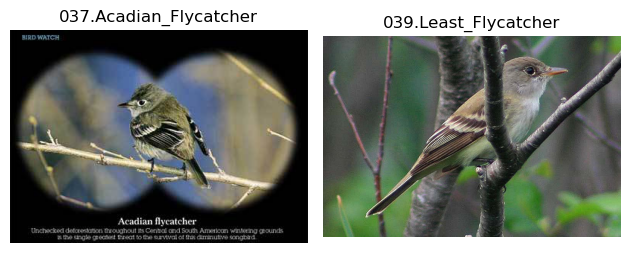

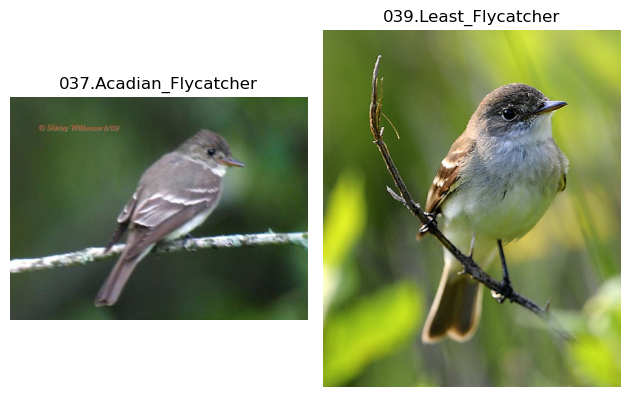

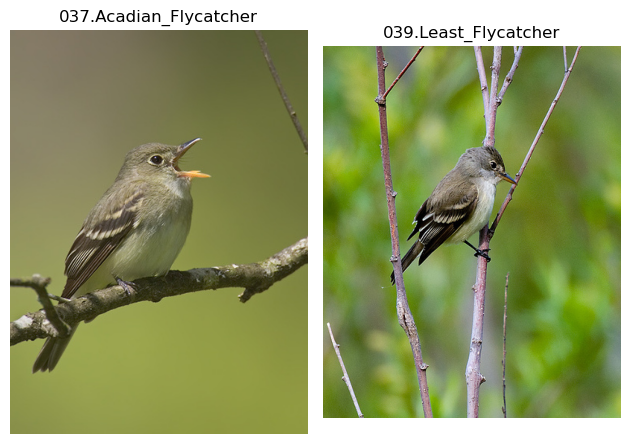

In [6]:
#Plot images of birds with most similar embeddings
plot_pair_images('037.Acadian_Flycatcher', '039.Least_Flycatcher')

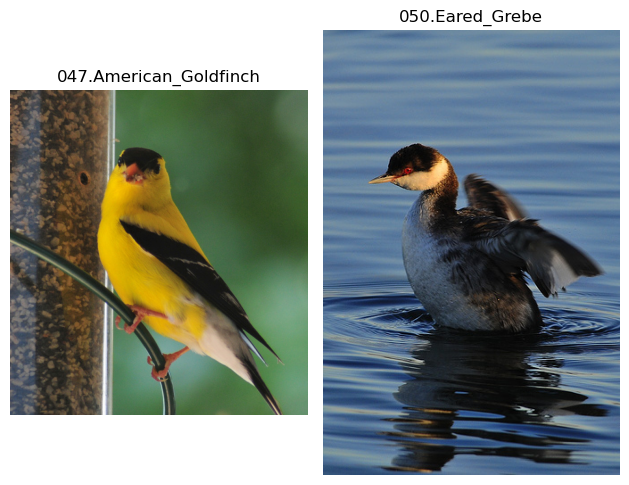

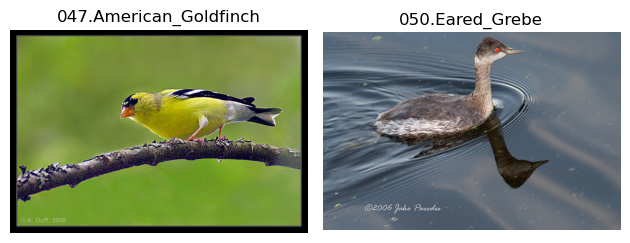

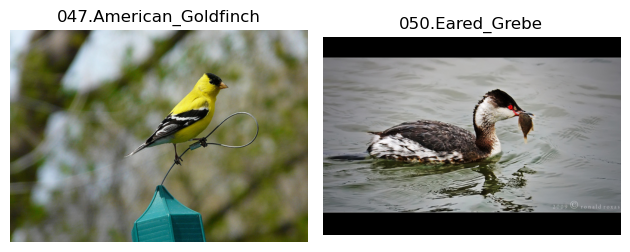

In [7]:
#Plot images of birds with least similar embeddings
plot_pair_images('047.American_Goldfinch', '050.Eared_Grebe') 

## Code & Results

Follow the guidelines in the `README` file

In [8]:
# Creating new folder for training

# Define the source folder where the pairs are located
source_folder = "CUB_200_2011/images"

# Define the destination folder where the files will be copied
destination_folder = "birds"

# Define the pairs of files
pairs = my_working_pairs

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate over each pair and copy the files to the destination folder
for i, pair in enumerate(pairs):
    file1, file2 = pair
    shutil.copytree(os.path.join(source_folder, file1), os.path.join(destination_folder, file1+"---"+file2, file1))
    shutil.copytree(os.path.join(source_folder, file2), os.path.join(destination_folder, file1+"---"+file2, file2))


In [9]:
def initiate_CNN():
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 200x200 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),
        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        # Only 1 output neuron. It will contain a value from 0-1 
        tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

In [10]:
# Training model to classify 

RMSprop = tf.keras.dtensor.experimental.optimizers.RMSprop

to_plot= {'x':[], 'y':[]}
models_dict = {}
for folder in os.listdir('birds'):
    model = initiate_CNN()
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics='accuracy')
    bird1, bird2 = folder.split('---')
    print(folder, similarity_dict[(bird1, bird2)])
    folder_path = os.path.join('birds', folder)
    training_set = tf.keras.utils.image_dataset_from_directory(
        folder_path,
        seed=123,
        image_size=(200, 200),
        subset='training',
        validation_split=0.3,
        batch_size=5)

    validation_set = tf.keras.utils.image_dataset_from_directory(
        folder_path,
        shuffle=True,
        seed=17,
        image_size=(200, 200),
        validation_split=0.3,
        subset='validation',
        batch_size=5)

    train_file_paths = training_set.file_paths
    validation_file_paths = validation_set.file_paths

    history = model.fit(training_set,
          epochs=10,
          verbose=0,
          validation_data = validation_set)
    models_dict[folder] = model

    # Save models' accuracy to plot
    to_plot['x'].append(similarity_dict[(bird1, bird2)])
    to_plot['y'].append(model.evaluate(validation_set)[1]) 

046.Gadwall---047.American_Goldfinch 0.48155648
Found 120 files belonging to 2 classes.
Using 84 files for training.
Found 120 files belonging to 2 classes.
Using 36 files for validation.
8/8 [==============================] - 0s 8ms/step - loss: 0.2382 - accuracy: 0.9167
038.Great_Crested_Flycatcher---043.Yellow_bellied_Flycatcher 0.9755447
Found 119 files belonging to 2 classes.
Using 84 files for training.
Found 119 files belonging to 2 classes.
Using 35 files for validation.
7/7 [==============================] - 0s 9ms/step - loss: 0.6630 - accuracy: 0.4857
037.Acadian_Flycatcher---039.Least_Flycatcher 0.9837071
Found 118 files belonging to 2 classes.
Using 83 files for training.
Found 118 files belonging to 2 classes.
Using 35 files for validation.
7/7 [==============================] - 0s 8ms/step - loss: 0.6363 - accuracy: 0.7714
023.Brandt_Cormorant---025.Pelagic_Cormorant 0.9700101
Found 119 files belonging to 2 classes.
Using 84 files for training.
Found 119 files belonging 

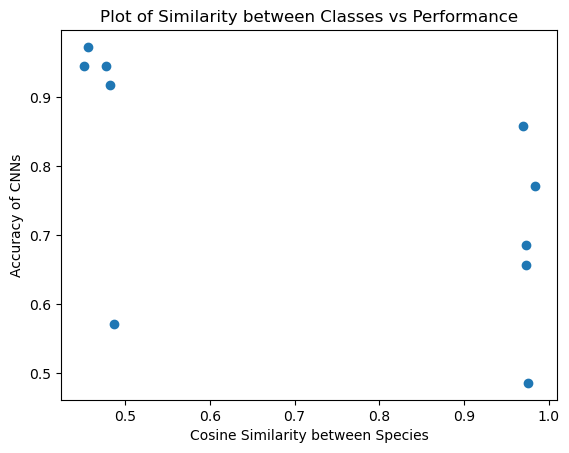

In [11]:
plt.scatter(to_plot['x'], to_plot['y'])
plt.xlabel('Cosine Similarity between Species')
plt.ylabel('Accuracy of CNNs')
plt.title('Plot of Similarity between Classes vs Performance')
plt.show()

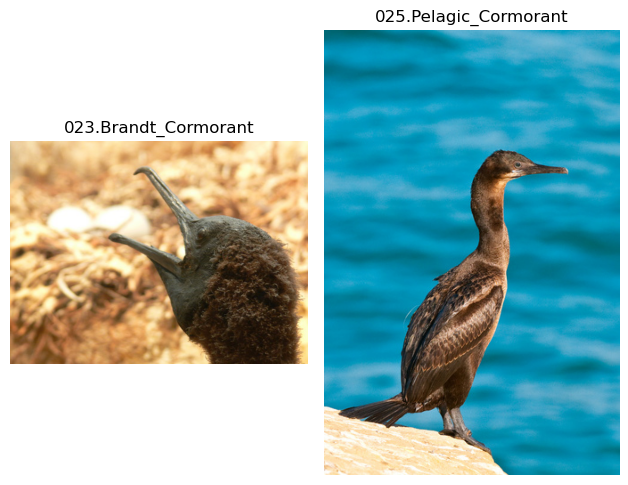

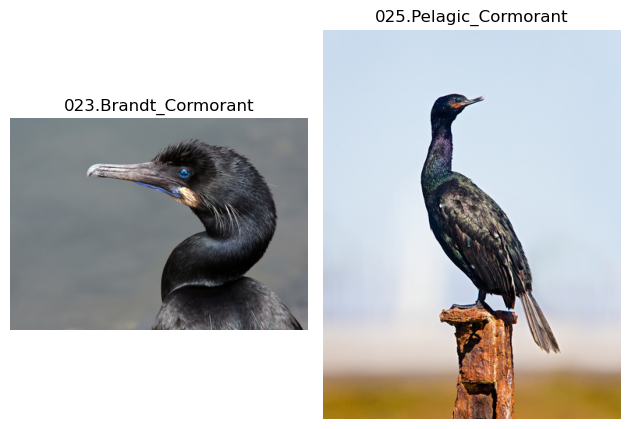

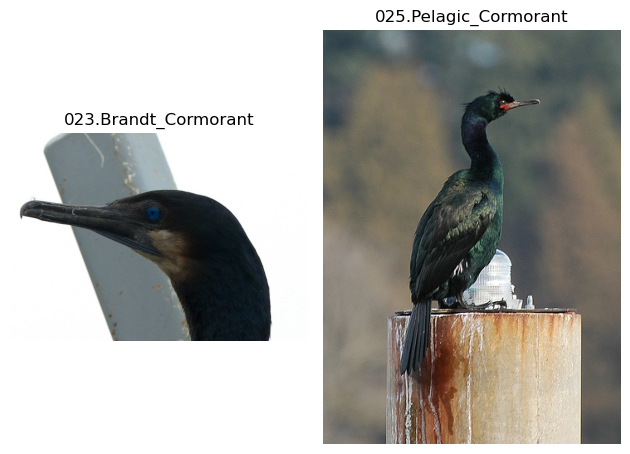

In [12]:
# Plot images of birds with high similar embeddings but CNN can classify correctly
plot_pair_images('023.Brandt_Cormorant', '025.Pelagic_Cormorant')

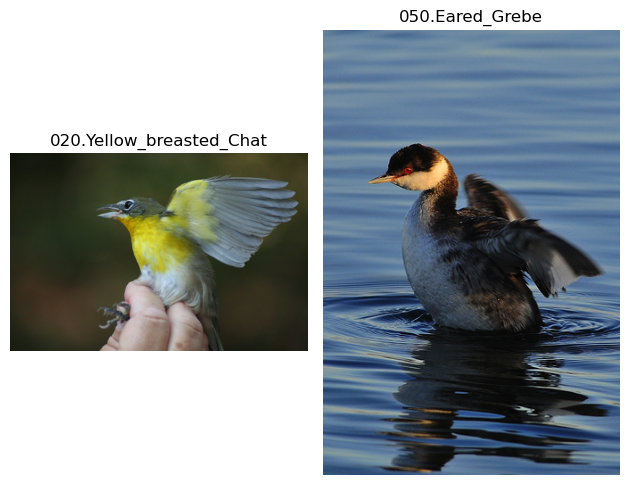

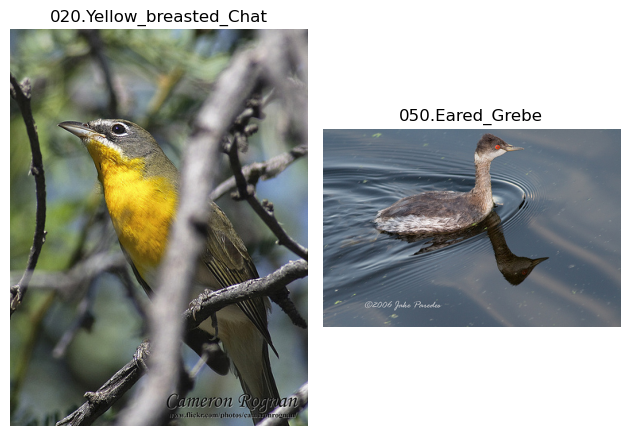

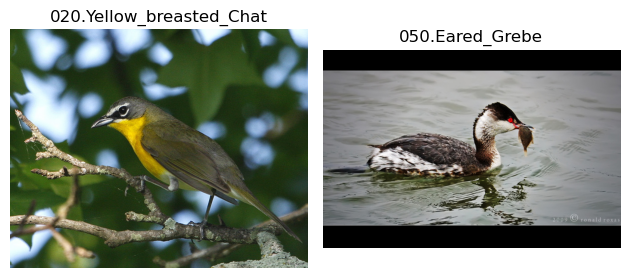

In [22]:
# Plot images of birds with low similar embeddings but CNN cannot classify correctly
plot_pair_images('020.Yellow_breasted_Chat', '050.Eared_Grebe')

### Ensemble 

In [13]:
folder_list = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]
new_folder_list = sorted(folder_list)[50:]

In [14]:
# Set up folder for Ensemble

file1, file2 = '070.Green_Violetear', '101.White_Pelican' # A random pair of species used to test the ensemble model

# Define the source folder where the pairs are located
source_folder = "CUB_200_2011/images"

# Define the destination folder where the files will be copied
destination_folder = "ensemble"

os.makedirs(destination_folder, exist_ok=True)

shutil.copytree(os.path.join(source_folder, file1), os.path.join(destination_folder, file1))
shutil.copytree(os.path.join(source_folder, file2), os.path.join(destination_folder, file2))

'ensemble/101.White_Pelican'

In [15]:
holdout_set_all = tf.keras.utils.image_dataset_from_directory(
  'ensemble',
  shuffle=False,
  seed=17,
  image_size=(200, 200),
  batch_size=1) # batch size has to be one for this set
images = []
labels = []
for e, image_label in enumerate(holdout_set_all):
    images.append(image_label[0].numpy())
    labels.append(image_label[1].numpy())
test_dataset = tf.data.Dataset.from_tensor_slices(images)
preds_dict = {}
for model_name in models_dict:
    print(model_name)
    model = models_dict[model_name]
    preds = model.predict(test_dataset)
    preds_dict[model_name] = preds.squeeze().tolist()


Found 110 files belonging to 2 classes.
046.Gadwall---047.American_Goldfinch
110/110 [==============================] - 0s 4ms/step
038.Great_Crested_Flycatcher---043.Yellow_bellied_Flycatcher
110/110 [==============================] - 0s 4ms/step
037.Acadian_Flycatcher---039.Least_Flycatcher
110/110 [==============================] - 0s 4ms/step
023.Brandt_Cormorant---025.Pelagic_Cormorant
110/110 [==============================] - 0s 4ms/step
020.Yellow_breasted_Chat---050.Eared_Grebe
110/110 [==============================] - 0s 4ms/step
001.Black_footed_Albatross---047.American_Goldfinch
110/110 [==============================] - 0s 4ms/step
047.American_Goldfinch---050.Eared_Grebe
110/110 [==============================] - 0s 4ms/step
037.Acadian_Flycatcher---043.Yellow_bellied_Flycatcher
110/110 [==============================] - 0s 4ms/step
014.Indigo_Bunting---050.Eared_Grebe
110/110 [==============================] - 0s 4ms/step
009.Brewer_Blackbird---027.Shiny_Cowbird
110/110

In [16]:
novel_species_df = pd.DataFrame()

# Add columns from preds_dict to the DataFrame
novel_species_df = novel_species_df.assign(**preds_dict)
novel_species_df['true_label'] = [i[0] for i in labels]
# Display the updated DataFrame
novel_species_df.head()


046.Gadwall---047.American_Goldfinch  \
0                              0.530877   
1                              0.012446   
2                              0.003816   
3                              0.012449   
4                              0.999969   

   038.Great_Crested_Flycatcher---043.Yellow_bellied_Flycatcher  \
0                                           0.697651              
1                                           0.553462              
2                                           0.519633              
3                                           0.519633              
4                                           0.519633              

   037.Acadian_Flycatcher---039.Least_Flycatcher  \
0                                       0.906035   
1                                       0.033120   
2                                       0.637166   
3                                       0.549367   
4                                       0.735798   

   023.Brandt_Cormorant---025.Pelagic_Cormorant  \
0                                      0.648609   
1                                      0.104081   
2                                      0.825960   
3                                      0.475063   
4                                      0.514278   

   020.Yellow_breasted_Chat---050.Eared_Grebe  \
0                                    0.684164   
1                                    0.128726   
2                                    0.614970   
3                                    0.577457   
4                                    0.487742   

   001.Black_footed_Albatross---047.American_Goldfinch  \
0                                           0.824229     
1                                           0.979780     
2                                           0.290546     
3                                           0.999926     
4                                           0.999896     

   047.American_Goldfinch---050.Eared_Grebe  \
0                              8.855044e-01   
1                              5.857675e-09   
2                              1.407814e-03   
3                              1.707059e-20   
4                              5.292500e-02   

   037.Acadian_Flycatcher---043.Yellow_bellied_Flycatcher  \
0                                           0.575820        
1                                           0.722117        
2                                           0.478368        
3                                           0.495773        
4                                           0.495773        

   014.Indigo_Bunting---050.Eared_Grebe  \
0                              0.012202   
1                              0.000026   
2                              0.885290   
3                              0.946846   
4                              0.035536   

   009.Brewer_Blackbird---027.Shiny_Cowbird  true_label  
0                                  0.099432           0  
1                                  0.304113           0  
2                                  0.453723           0  
3                                  0.537614           0  
4                                  0.523342           0

In [17]:
# After creating the DataFrame with features from 10 CNNs we have trained before, we can split the dataset into training and testing sets
X= novel_species_df.drop(['true_label'],axis=1)
y = novel_species_df['true_label']
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [18]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [19]:
prediction = logreg.predict(X_test)

In [20]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       0.85      0.73      0.79        15

    accuracy                           0.82        33
   macro avg       0.82      0.81      0.81        33
weighted avg       0.82      0.82      0.82        33



In [21]:

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=2)  # You can specify the number of neighbors (K) here

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test data
y_pred = knn.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.92      0.80      0.86        15

    accuracy                           0.88        33
   macro avg       0.89      0.87      0.88        33
weighted avg       0.88      0.88      0.88        33



## Interpretation

Follow the guidelines in the `README` file

## Conclusion

Follow the guidelines in the `README` file

## References


Van Horn, G., Branson, S., Farrell, R., Haber, S., Barry, J., Ipeirotis, P., Perona, P., & Belongie, S. (2015). Building a bird recognition app and large scale dataset with citizen scientists: The fine print in fine-grained dataset collection. 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). https://doi.org/10.1109/cvpr.2015.7298658 

Fareid. (2023, September 24). Image similarity using feature embeddings. Medium. https://medium.com/@f.a.reid/image-similarity-using-feature-embeddings-357dc01514f8 